# Linear fit of Bouguer lines on  AuxTel Data 2023/01/19 in one large wavelength bin for empty holo, PSF2DFFM, Rebin1


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : July 26th 2023
- update : July 26th 2023

** Kernel anaconda3_auxtel**

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

%matplotlib inline
import pickle
import h5py

In [2]:
import sys
sys.path

['/Volumes/Backup2020/MacOSX/GitHub/LSST/AuxTelComm/notebooks_usdf/BouguerLines/202307',
 '/Users/dagoret/opt/anaconda3/lib/python39.zip',
 '/Users/dagoret/opt/anaconda3/lib/python3.9',
 '/Users/dagoret/opt/anaconda3/lib/python3.9/lib-dynload',
 '',
 '/Users/dagoret/.local/lib/python3.9/site-packages',
 '/Users/dagoret/opt/anaconda3/lib/python3.9/site-packages',
 '__editable__.atmosphtransmemullsst-0.0.1.finder.__path_hook__',
 '/Users/dagoret/opt/anaconda3/lib/python3.9/site-packages/aeosa',
 '/Users/dagoret/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/dagoret/.ipython']

In [3]:
import scipy.odr
import scipy.optimize

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/6cf2109gm_tmc.fits',
 'thermtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [6]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [7]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit
from scipy.odr import Model,ODR,RealData
from scipy import linalg

In [8]:
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

iminuit version: 2.16.0


In [9]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [10]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [11]:
os.getenv("PYSYN_CDBS")

'/Volumes/Backup2020/PySynPhotData/grp/redcat/trds'

In [12]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
   
dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
             'HD200654': "hd200654_stis_006.fits",  
             'HD115169': "hd115169_stis_003.fits",
             'HD142331': "hd142331_stis_004.fits", 
             'HD167060': "hd167060_stis_004.fits", 
            'HD146233': "18sco_stis_004.fits"       
              }         


In [13]:
# Must divide the observed flux by this correction area
correction_area = 1.06/1.13

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [14]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [15]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [16]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [17]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [18]:
def GetColumnHfData(h5spectra,list_of_keys,nameval):
    """
    Extract h5file atttribute 
    
    parameters
      hf           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
      the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=h5spectra.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [19]:
def reorder(df,all_subgroup_keys):
    
    if 'me_az_rms' in all_subgroup_keys:
        df = df.reindex(columns=['index',
                         'exposure',
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                         "me_az_rms",
                         "me_el_rms",
                         "me_rot_rms",
                         "me_image_az_rms",
                         "me_image_el_rms",
                         "me_image_rot_rms",
                        ])
    else:
        df = df.reindex(columns=['index',
                         'exposure',
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                        ])
        
    return df

In [20]:
def get_seq(row):
    return row - (row//100000)*100000

In [21]:
def GetSpectraH5(h5spectra,factor=1.):
    """
    GetSpectraH5(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # pick one key    
    key_sel =  sorted_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    #d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opt
    
    idx=0
    for key in sorted_spectra_keys :
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
        
    #calculate refhour    
    all_datetime = [ Time(str_time).to_datetime() for str_time in df_info['spec_date_obs'] ]
    start_time_str = df_info["spec_date_obs"].min()
    stop_time_str = df_info["spec_date_obs"].max()
    startTime = Time(start_time_str).to_datetime()
    endTime =  Time(stop_time_str).to_datetime() 
    all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in df_info['spec_date_obs'] ]
    df_info["refhour"] = all_reftime
    #calculate number
    df_info["number"] = df_info[['exposure']].apply(lambda x: get_seq(x))
        
    return df_info , all_df

In [22]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [23]:
def GetSpectraH5Filtered(h5spectra,list_of_bad_spectra,factor=1.):
    """
    GetSpectraH5Filtered(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # compute the list of filtered spectra
    sorted_selected_spectra_keys = [] 
    for key in sorted_spectra_keys:
        key_num = int(key)
        seq = key_num - (key_num//100000)*100000
        if seq not in list_of_bad_spectra and str(seq) not in list_of_bad_spectra:
            sorted_selected_spectra_keys.append(key)
       
    
    # pick one key    
    key_sel =  sorted_selected_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_selected_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    #d = h5group.create_dataset("spec_lambdas",data=spec.lambdas,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data",data=spec.data,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err",data=spec.err,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_covmatrix",data=spec.cov_matrix,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_data_next_order",data=spec.data_next_order,compression="gzip", compression_opts=9)
    #d = h5group.create_dataset("spec_err_next_order",data=spec.err_next_order,compression="gzip", compression_opt
    
    idx=0
    for key in sorted_selected_spectra_keys:
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
    
    #calculate refhour    
    all_datetime = [ Time(str_time).to_datetime() for str_time in df_info['spec_date_obs'] ]
    start_time_str = df_info["spec_date_obs"].min()
    stop_time_str = df_info["spec_date_obs"].max()
    startTime = Time(start_time_str).to_datetime()
    endTime =  Time(stop_time_str).to_datetime() 
    all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in df_info['spec_date_obs'] ]
    df_info["refhour"] = all_reftime
    #calculate number
    df_info["number"] = df_info[['exposure']].apply(lambda x: get_seq(x))
    
    
    
    return df_info , all_df

In [24]:
class SimpleAtmEmulator:
    """
    Emulate Atmospheric Transparency above LSST from a data grids
    extracted from libradtran and analytical functions for aerosols.
    There are 3 grids:
    - 2D grid Rayleigh transmission vs (wavelength,airmass)
    - 2D grid O2 absorption vs  (wavelength,airmass)
    - 3D grid for PWV absorption vs (wavelength,airmass,PWV)
    - 3D grid for Ozone absorption vs (wavelength,airmass,Ozone)
    - Aerosol transmission for any number of components
    
    """
    def __init__(self,path='../data/simplegrid'):
        """
        Initialize the class for data point files from which the 2D and 3D grids are created.
        Interpolation are calculated from the scipy RegularGridInterpolator() function
        
        """
        self.path = path
        self.fn_info_training = "atmospherictransparencygrid_params_training.pickle"
        self.fn_info_test = "atmospherictransparencygrid_params_test.pickle"
        self.fn_rayleigh_training = "atmospherictransparencygrid_rayleigh_training.npy"
        self.fn_rayleigh_test = "atmospherictransparencygrid_rayleigh_test.npy"
        self.fn_O2abs_training = "atmospherictransparencygrid_O2abs_training.npy"
        self.fn_O2abs_test = "atmospherictransparencygrid_O2abs_test.npy"
        self.fn_PWVabs_training = "atmospherictransparencygrid_PWVabs_training.npy"
        self.fn_PWVabs_test = "atmospherictransparencygrid_PWVabs_test.npy"
        self.fn_OZabs_training = "atmospherictransparencygrid_OZabs_training.npy"
        self.fn_OZabs_test = "atmospherictransparencygrid_OZabs_test.npy"

        self.info_params_training = None
        self.info_params_test = None
        self.data_rayleigh_training = None
        self.data_rayleigh_test = None
        self.data_O2abs_training = None
        self.data_O2abs_test = None
        self.data_PWVabs_training = None
        self.data_PWVabs_test = None
        self.data_OZabs_training = None
        self.data_OZabs_test = None
        
        self.loadtables()
        
        self.WLMIN = self.info_params_training["WLMIN"]
        self.WLMAX = self.info_params_training["WLMAX"]
        self.WLBIN = self.info_params_training["WLBIN"]
        self.NWLBIN = self.info_params_training['NWLBIN']
        self.WL = self.info_params_training['WL']
        
        self.AIRMASSMIN = self.info_params_training['AIRMASSMIN']
        self.AIRMASSMAX = self.info_params_training['AIRMASSMAX']
        self.NAIRMASS = self.info_params_training['NAIRMASS']
        self.DAIRMASS = self.info_params_training['DAIRMASS']
        self.AIRMASS = self.info_params_training['AIRMASS']
        
        self.PWVMIN = self.info_params_training['PWVMIN']
        self.PWVMAX = self.info_params_training['PWVMAX'] 
        self.NPWV = self.info_params_training['NPWV']
        self.DPWV = self.info_params_training['DPWV'] 
        self.PWV = self.info_params_training['PWV']
        
        
        self.OZMIN =  self.info_params_training['OZMIN']
        self.OZMAX = self.info_params_training['OZMAX']
        self.NOZ = self.info_params_training['NOZ']
        self.DOZ =  self.info_params_training['DOZ'] 
        self.OZ = self.info_params_training['OZ']
        
        
        self.lambda0 = 550.
        self.tau0 = 1.


        self.func_rayleigh_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_rayleigh_training)
        self.func_O2abs_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_O2abs_training)
        self.func_PWVabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.PWV),self.data_PWVabs_training)
        self.func_OZabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.OZ),self.data_OZabs_training)

        
        
    def loadtables(self):
        """
        Load files into grid arrays
        """
        
        filename=os.path.join(self.path,self.fn_info_training)     
        with open(filename, 'rb') as f:
            self.info_params_training = pickle.load(f)
            
        filename=os.path.join(self.path,self.fn_info_test)     
        with open(filename, 'rb') as f:
            self.info_params_test = pickle.load(f)        
        
        filename=os.path.join(self.path,self.fn_rayleigh_training)
        with open(filename, 'rb') as f:
            self.data_rayleigh_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_rayleigh_test)
        with open(filename, 'rb') as f:
            self.data_rayleigh_test=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_training)
        with open(filename, 'rb') as f:
            self.data_O2abs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_test)
        with open(filename, 'rb') as f:
            self.data_O2abs_test=np.load(f)
                  
        filename=os.path.join(self.path,self.fn_PWVabs_training)
        with open(filename, 'rb') as f:
            self.data_PWVabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_PWVabs_test)
        with open(filename, 'rb') as f:
            self.data_PWVabs_test=np.load(f)
            
            
        filename=os.path.join(self.path,self.fn_OZabs_training)
        with open(filename, 'rb') as f:
            self.data_OZabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_OZabs_test)
        with open(filename, 'rb') as f:
            self.data_OZabs_test=np.load(f)

    def GetWL(self):
        return self.WL
            
    def GetRayleighTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_rayleigh_train(pts)
    
    
    def GetO2absTransparencyArray(self,wl,am):
        pts = [ (the_wl,am) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_O2abs_train(pts)
    
    
    def GetPWVabsTransparencyArray(self,wl,am,pwv):
        pts = [ (the_wl,am,pwv) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_PWVabs_train(pts)
    
    
    def GetOZabsTransparencyArray(self,wl,am,oz):
        pts = [ (the_wl,am,oz) for the_wl in wl ]
        pts = np.array(pts)
        return self.func_OZabs_train(pts)
            

    
    def GetGriddedTransparencies(self,wl,am,pwv,oz,flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True):
        """
        Emulation of libradtran simulated transparencies. Decomposition of the
        total transmission in different processes:
        - Rayleigh scattering
        - O2 absorption
        - PWV absorption
        - Ozone absorption
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        


        if flagRayleigh:
            transm = self.GetRayleighTransparencyArray(wl,am)
        else:
            transm = np.ones(len(wl))
            
        if flagO2abs:
            transm *= self.GetO2absTransparencyArray(wl,am)
            
        if flagPWVabs:
            transm *= self.GetPWVabsTransparencyArray(wl,am,pwv)
            
        if flagOZabs:
            transm *= self.GetOZabsTransparencyArray(wl,am,oz)
            
        return transm
            
    def GetAerosolsTransparencies(self,wl,am,ncomp,taus=None,betas=None):
        """
        Compute transmission due to aerosols:
        
        inputs:
        - wl : wavelength array
        - am : the airmass
        - ncomp : the number of aerosol components
        - taus : the vertical aerosol depth of each component at lambda0 vavelength
        - betas : the angstrom exponent. Must be negativ.
        
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
          
        wl = np.array(wl)
        NWL=wl.shape[0]
        
        transm = np.ones(NWL)
        
        if ncomp <=0:
            return transm
        else:
            taus=np.array(taus)
            betas=np.array(betas)
            
            NTAUS=taus.shape[0]
            NBETAS=betas.shape[0]
        
            assert ncomp<=NTAUS
            assert ncomp<=NBETAS     
        
            for icomp in range(ncomp):            
                exponent = (taus[icomp]/self.tau0)*np.exp(betas[icomp]*np.log(wl/self.lambda0))*am
                transm *= np.exp(-exponent)
            
            return transm
        
        
    def GetAllTransparencies(self,wl,am,pwv,oz,ncomp=0, taus=None, betas=None, flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True,flagAerosols=False):
        """
        Combine interpolated libradtran transmission with analytical expression for the
        aerosols
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - ncomp : number of aerosols components,
        - taus & betas : arrays of parameters for aerosols
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        
        
        transm = self.GetGriddedTransparencies(wl,am,pwv,oz,flagRayleigh=flagRayleigh,flagO2abs=flagO2abs,flagPWVabs=flagPWVabs,flagOZabs=flagOZabs)
        
        if flagAerosols:
            transmaer = self.GetAerosolsTransparencies(wl,am,ncomp,taus,betas)
            transm *=transmaer
           
            
        return transm
            

In [25]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)  
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["spec_airmass"].iloc[idx]
        time_table[idx]  = info["refhour"].iloc[idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [26]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    GetBouguerLinesTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    Input arguments :
    
    - Npoints : number of wavelength samples,
    - wl: array of wavelength
    - time : array of time
    - magref : reference of magnitudes array (2d)
    
    Return:
     plot only
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    # create label
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    # number of wavelength bins
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    # the abscisse is the time
    the_x=tim
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop over bouguer lines (big wl bins)
    for idx in np.arange(N):     
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]   
        
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right',bbox_to_anchor=(1.05,1))
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [27]:
def GetBouguerLinesUTCTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    GetBouguerLinesUTCTim(Npoints,wl,tim,magref ,emag,title="atmospheric transmission vs time",FLAG_PLOT=True,YMIN=0,YMAX=0):
    Input arguments :
    
    - Npoints : number of wavelength samples,
    - wl: array of wavelength
    - time : array of time
    - magref : reference of magnitudes array (2d)
    
    Return:
     plot only
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    # create label
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    # number of wavelength bins
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    # the abscisse is the time
    the_x=tim
    
    #x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop over bouguer lines (big wl bins)
    for idx in np.arange(N):     
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]   
        
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
            ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1., ecolor=all_colors[idx], elinewidth = 1.)
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right',bbox_to_anchor=(1.05,1))
        
        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)
        ax.xaxis.set_tick_params(rotation=45)

        
        #ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (UTC)")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
        
     
    return 
     

In [28]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,emag,title="magnitude vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    Compute bouguer lines in large bins
    
    input parameters:
        -  Npoints : Number of bouguer lines required in the bouguer lines
        -  wl array of wavelength at input
        - airmass array at input
        - magref : magnitude aray
        - emag :  magnitude error array
        
        
        
    return:
        - wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    print("wl_binwidth = ",wl_binwidth)
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    
    # the absisse is the airmass 
    the_x=airmass
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

        
    # loop on wavelength    
    fit_results = []
    fit_flag = []
    
    
    # loop on bouguer lines
    for idx in np.arange(N):
        
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]
        
        # number in wl bins
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute the average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on the average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
      
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
       
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
       
            if popt[0] > 0 :
                # plot points
                ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
    
                # plot fitted lines
                ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
            
            else:
                msg = f"Remove wavelength {wl0} nm, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
            
                
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
                       
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

In [29]:
def GetBouguerLinesAtmRelativetoZero(Npoints,wl,airmass,magref ,emag,title="magnitude vs airmass",FLAG_PLOT=True,YMIN=0,YMAX=0,WLMIN=350,WLMAX=1100):
    """
    
    Compute bouguer lines in large bins and remove zero-airmass magnitude
    
    input parameters:
        -  Npoints : Number of bouguer lines required in the bouguer lines
        -  wl array of wavelength at input
        - airmass array at input
        - magref : magnitude aray
        - emag :  magnitude error array
        
    return :
        - wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
    
    """
    
    # determine the wavelength output range
    if WLMIN == 0 and WLMAX == 0:
        WLMIN=wl.min()
        WLMAX=wl.max()
    
    # define the range of bin centers
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints,endpoint=True)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    
    # compute the bin width
    wl_binwidth1=(WLMAX-WLMIN)/(Npoints-1)
    wl_binwidth2=np.median(np.diff(wl_sel))
    wl_binwidth = wl_binwidth2
    
    # numbers of Bouguer lines
    NIWSEL=len(wl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(16,10))
        ax=fig.add_subplot(111)

    # loop on Bouguer lines at different wavelength 
    fit_results = [] # contains the result of the fit popt
    fit_flag = []    # quality flag
    
    for idx in np.arange(N):
        
        
        # central wavelength
        wl0=wl_sel[idx]
        
        # indexes in the input arrays
        idx_in_wlrange = np.where(np.logical_and(wl >= wl0-wl_binwidth/2,wl < wl0+wl_binwidth/2))[0]
        
        all_the_y_inwlbin=magref[:,idx_in_wlrange]
        all_the_ey_inwlbin=emag[:,idx_in_wlrange]
        
        # number in wl bins
        n_in_bin = len(all_the_y_inwlbin)
        
        # compute the average
        the_y = np.median(all_the_y_inwlbin,axis=1)
        # compute error on the average
        the_ey = np.sqrt(np.mean(all_the_ey_inwlbin**2,axis=1))/np.sqrt(n_in_bin)
        
                    
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        fit_results.append(popt)
        
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        intercept =  popt[-1]
        
        
        
        if FLAG_PLOT:
            
            if popt[0] > 0 : 
                ax.plot(the_x,the_y - intercept,'+',color=all_colors[idx],label=wl_label[idx])
                ax.errorbar(the_x,the_y - intercept,yerr=the_ey, fmt = '+', color=all_colors[idx],capsize = 1, ecolor=all_colors[idx], elinewidth =1)
            
                ax.plot(x_fit,y_fit - intercept,'-',color=all_colors[idx])
                ax.fill_between(x_fit,y_fit_up- intercept, y_fit_dw - intercept, alpha=.25, color="gray")
                
            
            else:
                msg = f"Remove wavelength {wl0}, bad fit slope = {popt[0]}, intercept = {popt[-1]}"
                print(msg)
               
       
        if popt[0] > 0 : 
            fit_flag.append(True) 
        else:
            fit_flag.append(False) 
            
    
    
    if FLAG_PLOT:
        ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude")
        ax.set_title(title,fontsize=20,fontweight='bold')
        if not (YMIN==0 and YMAX==0) and (YMAX>YMIN):
            ax.set_ylim(YMIN,YMAX)
        plt.show()
     
    return wl_sel,Mags,EMags,np.array(fit_flag),np.array(fit_results)
     

# Constants

# Initialisation

In [30]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [31]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-07-26 14:44:09,082 iMac-de-Sylvie.local __main__[4370] INFO LA time:05:44:09
2023-07-26 14:44:09,084 iMac-de-Sylvie.local __main__[4370] INFO NY time:08:44:09
2023-07-26 14:44:09,094 iMac-de-Sylvie.local __main__[4370] INFO London time:13:44:09
2023-07-26 14:44:09,100 iMac-de-Sylvie.local __main__[4370] INFO Paris time:14:44:09
2023-07-26 14:44:09,101 iMac-de-Sylvie.local __main__[4370] INFO ************************ START *********************


In [32]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [33]:
DATE = 20230119
FILTERTYPE = "empty~holo4_003"
spectractormode = "psf2dffm"
ext = "rebin1"   # run BPS by removing ACQ
FLAG_POLAR = False

In [34]:
# config file
# --------------
#configfile = "config/default.ini"
if ext == None or ext == "":
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}.ini"
else:
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}_{ext}.ini"
    
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2023-07-26 14:44:09,140 iMac-de-Sylvie.local __main__[4370] INFO Configuration file : config/20230118/empty~holo4_003/confprog_run-auxtel-20230118-empty~holo4_003_psf2dffm_rebin1.ini


In [35]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2023-07-26 14:44:09,149 iMac-de-Sylvie.local __main__[4370] INFO 1) Configuration


In [36]:
config_section = config.sections()

In [37]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [38]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
    #filename_redfilter        = config['GENERAL']['filename_redfilter']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    spectractormode = config['GENERAL']['spectractormode']
    
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
                                
    correction_area = float(config['GENERAL']['correction_area'])                           
                                
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    FLUXLIMMIN       = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX      = float(config['GENERAL']['FLUXLIMMAX'])
    
    MAGLIMMIN       = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX      = float(config['GENERAL']['MAGLIMMAX'])
    
    
    WLBINWIDTH  =  float(config['GENERAL']['WLBINWIDTH'])
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    
    FLAG_CORREC_GREY_ATT = bool(int(config['GENERAL']['FLAG_CORREC_GREY_ATT']))
    GREY_ATT_COEFS = config['GENERAL']['GREY_ATT_COEFS']
    
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [39]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2023-07-26 14:44:09,233 iMac-de-Sylvie.local __main__[4370] INFO  Object observed HD38666 at AUXTEL/Rubin Obs (2023-01-18)


In [40]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [41]:
inputfile

'allspectra_20230118-empty~holo4_003-PSF2DFFM_REBIN1-specV2.5-oga.hdf5'

In [42]:
list_of_badnums1 = [int(nn)  for nn in  BADEXPOS.split()]
list_of_badnums1

[207,
 208,
 217,
 226,
 227,
 263,
 264,
 273,
 274,
 299,
 300,
 312,
 313,
 396,
 419,
 420,
 444,
 445,
 455,
 463,
 464,
 482,
 501,
 563,
 562,
 564,
 572,
 582,
 608,
 609,
 618,
 627,
 653,
 671,
 672,
 707,
 708]

In [43]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [44]:
if FLAG_CORREC_GREY_ATT:
    list_of_greyattcoef = [locale.atof(val)  for val in GREY_ATT_COEFS.split()]
else:
    list_of_greyattcoef = []  

In [45]:
list_of_greyattcoef = np.array(list_of_greyattcoef)
list_of_greyattcoef

array([], dtype=float64)

In [46]:
len(list_of_greyattcoef)

0

In [47]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [48]:
dict_f_sed = {}
dict_name_sed = {}

In [49]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10*normalisationfactor
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_004.fits
HD111980 -> hd111980_stis_003.fits
HD37962 -> hd37962_stis_005.fits
Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
HD031128 -> hd031128_stis_005.fits
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
HD14943 -> hd14943_stis_005.fits
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
HD38949 -> hd38949_stis_005.fits
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
HD200654 -> hd200654_stis_006.fits
HD115169 -> hd115169_stis_003.fits
Warning, 70 of 6817 bins contained negative fluxes; they have been set to zero.
HD142331 -> hd142331_stis_004.fits
Warning, 67 of 6816 bins contained negative fluxes; they have been set to zero.
HD167060 -> hd167060_stis_004.fits

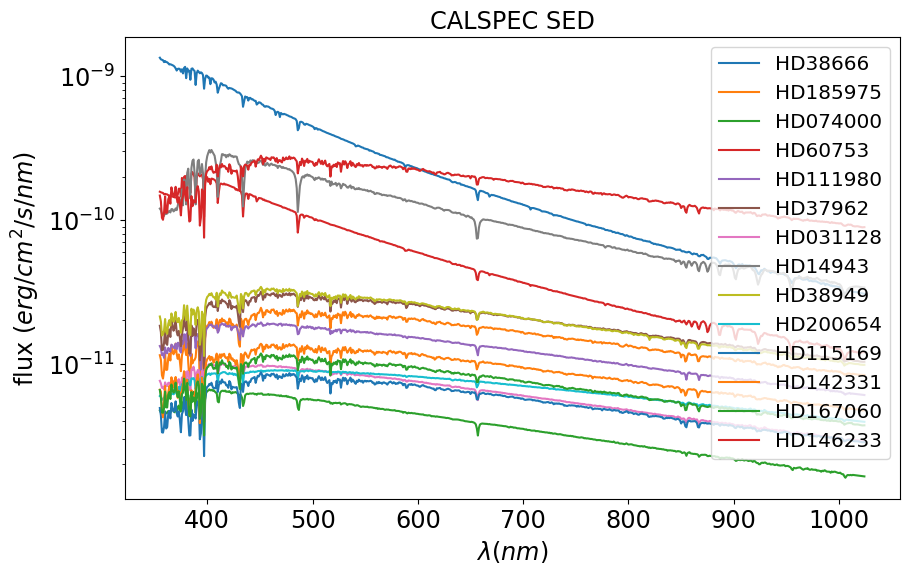

In [50]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")


In [51]:
if FLAG_POLAR:
    sed_w = WL
    sed_f = dict_f_sed["HD185975"](WL) 
    sed_m=-2.5*np.log10(sed_f)
    target = "HD185975"
else:
    sed_w = WL
    sed_f = dict_f_sed[target](WL) 
    sed_m=-2.5*np.log10(sed_f)

# spectrum data

In [52]:
fullfilename=os.path.join(inputdir,inputfile)

In [53]:
#with open(fullfilename, 'rb') as f:
#    summary_content = pickle.load(f)
    
hf =  h5py.File(fullfilename, 'r') 
list_of_keys = list(hf.keys())

In [54]:
#NBSPECTRA=len(summary_content)
NBSPECTRA=len(list_of_keys)

In [55]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2023-07-26 14:44:10,793 iMac-de-Sylvie.local __main__[4370] INFO  Number of selected files is 42


In [56]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [57]:
normalisationfactor

1.0

In [58]:
#infos, all_spectra = GetSpectra(summary_content)
infos, all_spectra = GetSpectraH5(hf,factor = normalisationfactor)

In [59]:
infos.head()

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,...,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,refhour,number
0,0,2023011800207,2023-01-19T00:51:33.404506808Z,HD38666,empty,1.083301,0,0,0,-26.493114,...,1121,3394,1547,1916,2,5666.666667,2273,369,0.000000,207
1,1,2023011800217,2023-01-19T00:57:43.847004258Z,HD38666,empty,1.073385,0,0,0,-24.946060,...,1081,3355,1549,1918,2,5666.666667,2274,369,0.102778,217
2,2,2023011800227,2023-01-19T01:03:38.322003085Z,HD38666,empty,1.064966,0,0,0,-23.533156,...,1170,3444,1576,1945,2,5666.666667,2274,369,0.201111,227
3,3,2023011800249,2023-01-19T01:25:22.309003658Z,HD185975,empty,2.056715,0,0,0,-237.532779,...,1125,3398,1598,1967,2,5666.666667,2273,369,0.563333,249
4,4,2023011800264,2023-01-19T01:37:54.634503460Z,HD38666,empty,1.025544,0,0,0,-14.868729,...,2828,3994,3637,4002,2,5666.666667,1166,365,0.772500,264


In [60]:
all_spectra[0].head()

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,297.027746,1.548937e-13,1.752181e-14,297.027746,-1.098230e-12,1.242333e-13
1,297.382430,1.546646e-13,1.194954e-14,297.382430,-1.096605e-12,8.472480e-14
2,297.737112,1.426180e-13,8.391353e-15,297.737112,-1.011192e-12,5.949648e-14
3,298.091790,9.914753e-14,9.519416e-15,298.091790,-7.029771e-13,6.749469e-14
4,298.446467,1.795708e-14,1.084789e-14,298.446467,-1.273195e-13,7.691384e-14


In [61]:
N=len(infos)
NX=4
NY=N/NX
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

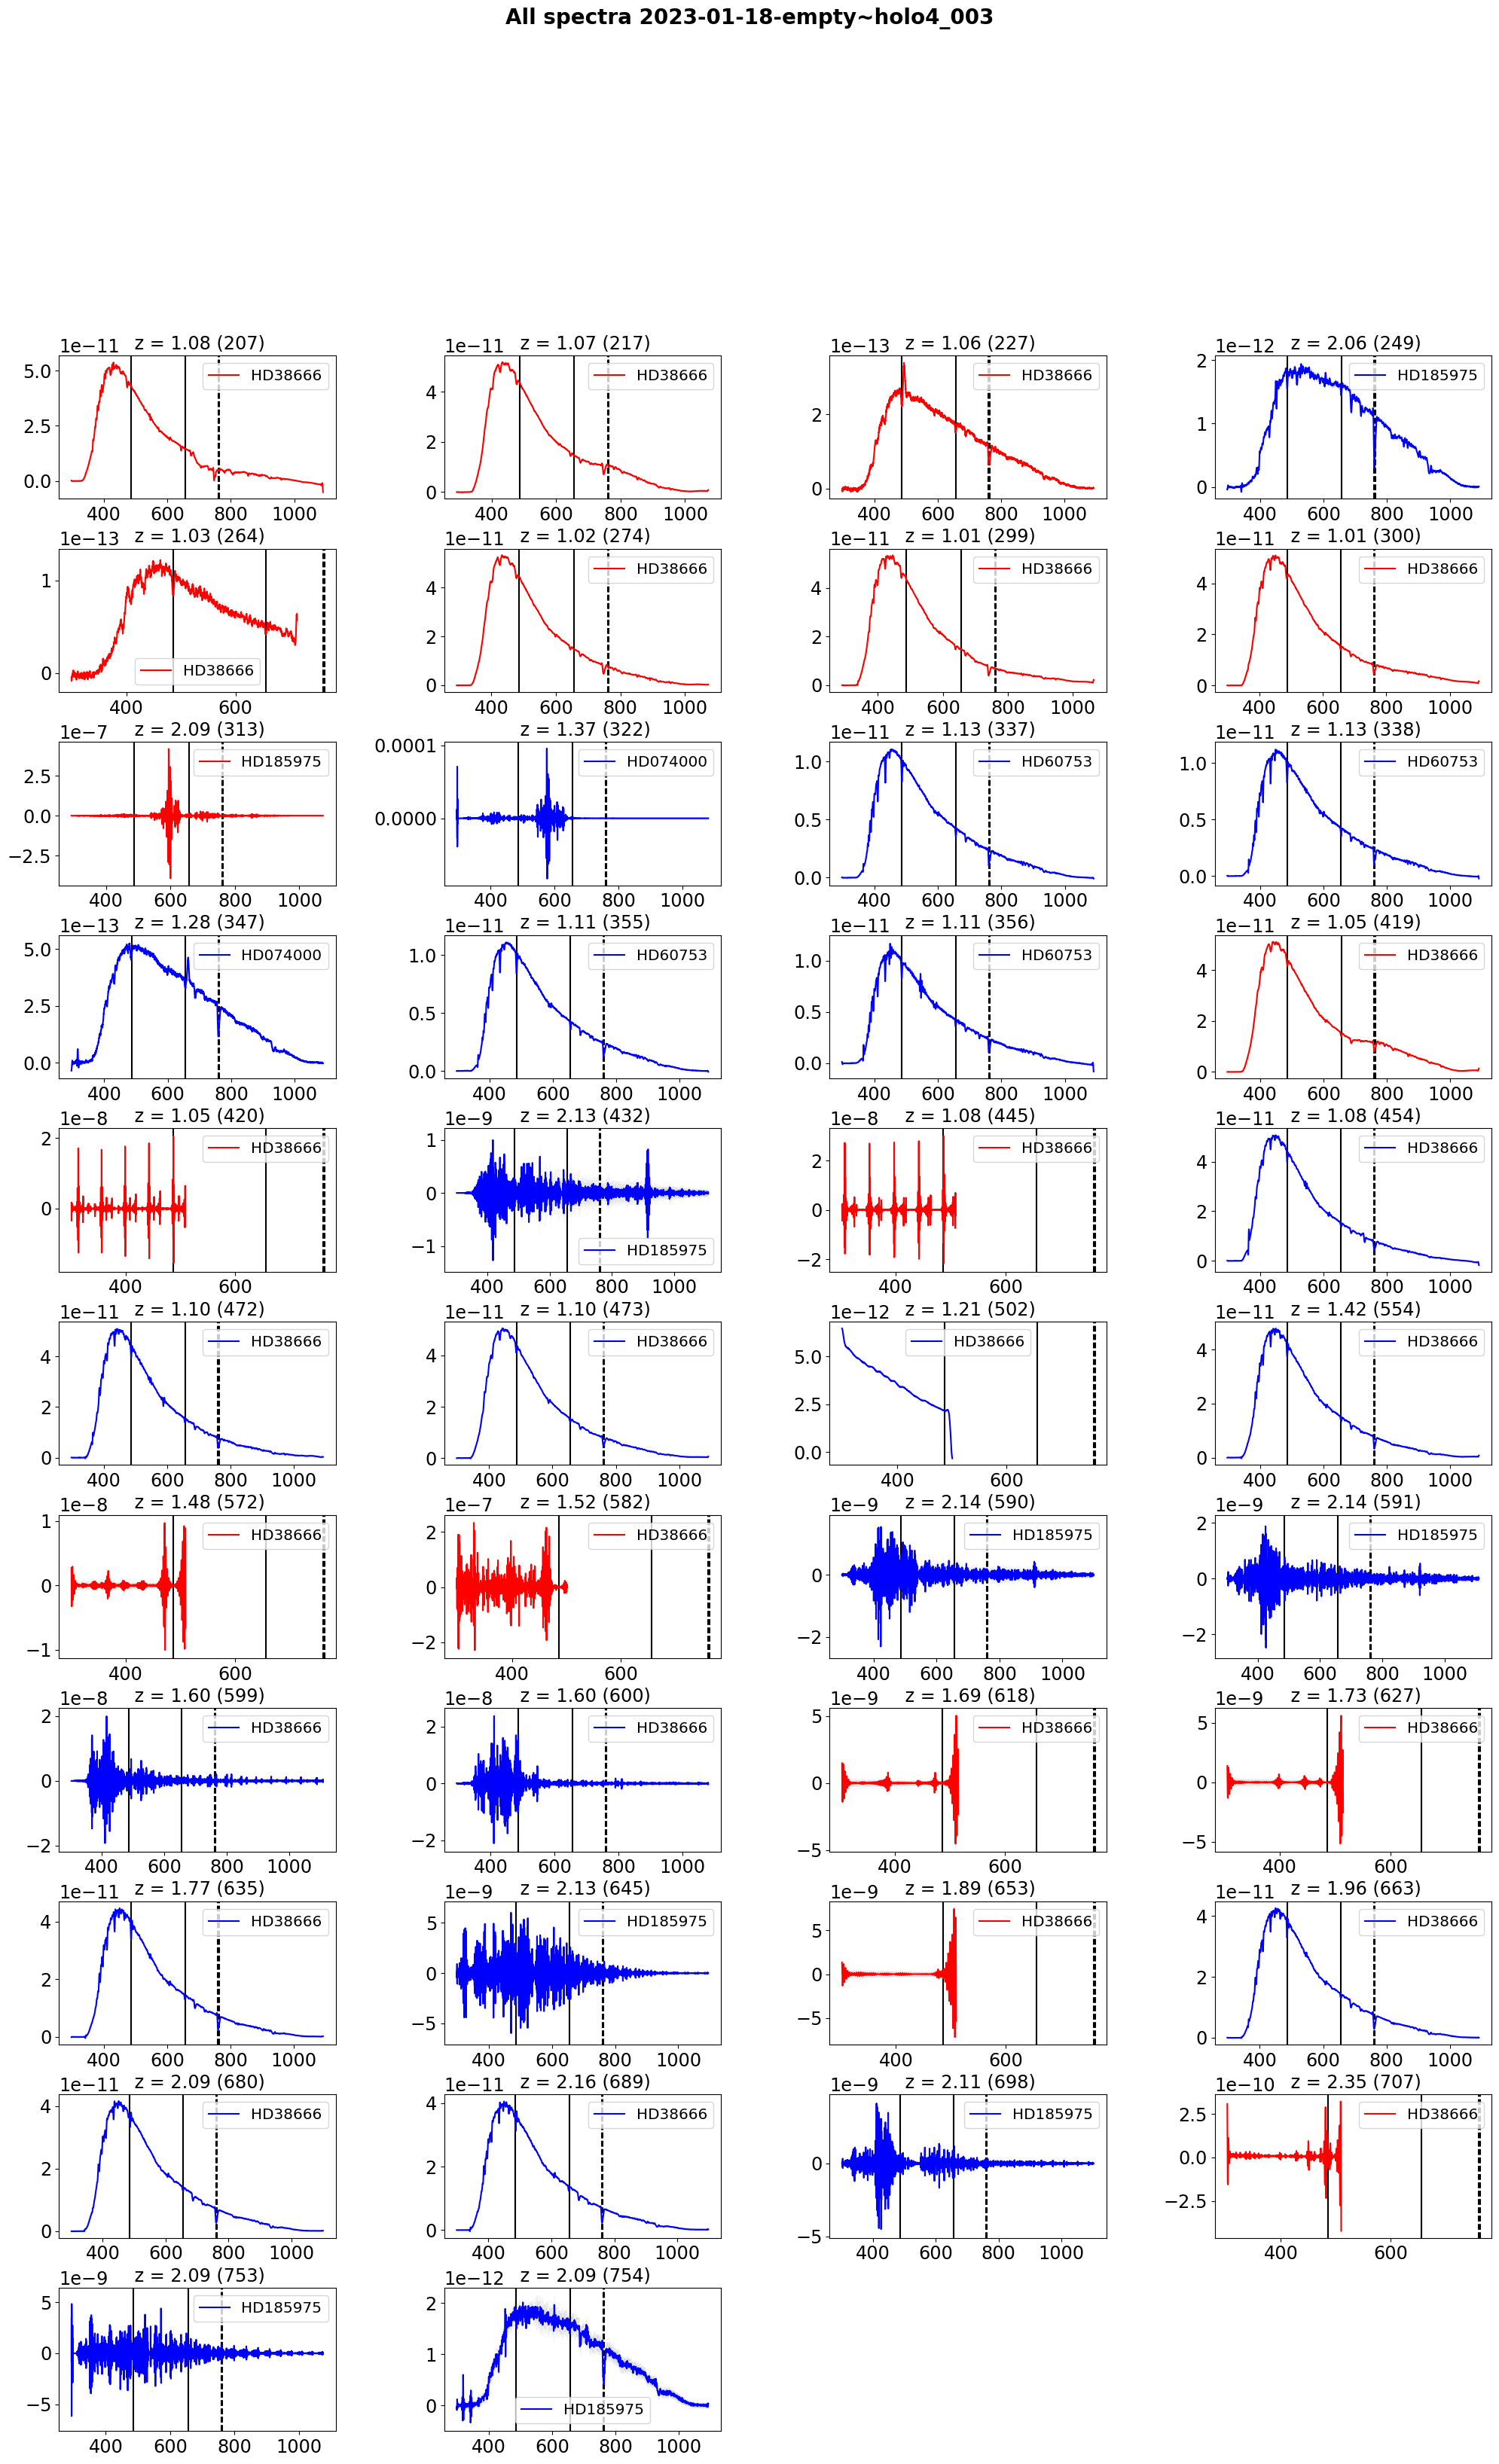

In [62]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["spec_header_airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["spec_target_label"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
    
the_title = f"All spectra {DATE}-{filterdisperser}"

plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_01-{DATE}-{filterdisperser}-allspectra.pdf"
plt.savefig(fig_filename)
plt.show()

# Remove bad Spectra

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.spec_target_label);
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target before spectra selection ")

Text(0.5, 1.0, 'nb of spectra per target before spectra selection ')

In [ ]:
infos

In [ ]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.spec_header_d2ccd,bins=20,range=(170,200));
ax.set_xlabel("spec_header_dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.spec_header_targetx,bins=50,range=(0,500));
ax.set_xlabel("spec_header_targetx")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.spec_header_targety,bins=50,range=(0,2000));
ax.set_xlabel("spec_header_targety")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [ ]:
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
selection_cut = ((infos.spec_header_d2ccd > 178) & (infos.spec_header_d2ccd < 182))
bad_cut = ~selection_cut

In [ ]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

In [ ]:
list_of_badnums2  = np.array([])

## Remove some targets

In [ ]:
AA = infos["spec_target_label"] == "HD115169"
AB = infos["spec_target_label"] == "HD142331"
AC = infos["spec_target_label"] == "HD146233"
AD = infos["spec_target_label"] == "HD42525"
AE = infos["spec_target_label"] == "HD73495"
AF = infos["spec_target_label"] == "HD167060"
AG = infos["spec_target_label"] == "HD111980"
AH = infos["spec_target_label"] == "HD200654"
AI = infos["spec_target_label"] == "HD60753"
AJ = infos["spec_target_label"] == "HD38949" 	
AK = infos["spec_target_label"] == "HD38666" 
AL = infos["spec_target_label"] == "HD38949"
AM = infos["spec_target_label"] == "HD031128" 	
AN = infos["spec_target_label"] == "HD14943"
AO = infos["spec_target_label"] == "HD074000"
AP = infos["spec_target_label"] == "HD2811" 	
AQ = infos["spec_target_label"] == "HD009051"
AR = infos["spec_target_label"] == "HD205905" 
AS = infos["spec_target_label"] == "HD37962" 	

 	
if FLAG_POLAR:
    selection_cut3 =  AA | AB | AC | AD | AE | AF | AG | AH | AI | AJ | AK | AL | AM | AN | AO | AP | AQ | AR | AS
    list_of_badnum3 = infos[selection_cut3]["number"].values
else:
    #selection_cut3 =  AC | AD | AE 
    selection_cut3 =  infos["spec_target_label"] == target
    list_of_badnum3 = infos[~selection_cut3]["number"].values

In [ ]:
list_of_badnum3

## Union of badnums

In [ ]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums = np.union1d(list_of_badnums,list_of_badnum3)
list_of_badnums=np.unique(list_of_badnums)


In [ ]:
#infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums)
infos, all_spectra = GetSpectraH5Filtered(hf,list_of_bad_spectra = list_of_badnums , factor = normalisationfactor)

In [ ]:
#infos["number"] = infos[['exposure']].apply(lambda x: get_seq(x))

In [ ]:
print("Number of spectra : ",len(all_spectra))

In [ ]:
infos.reset_index(drop=True, inplace=True)

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.spec_target_label);
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target after spectra selection ")


In [ ]:
infos.head()

In [ ]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['spec_date_obs'] ]
numbers = infos['number'].values
airmasses = infos['spec_airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  all_datetime[-1]

# relative hour
all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in infos['spec_date_obs'] ]

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(111)


y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
#ax2.invert_yaxis()
#ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    


ax2.invert_yaxis()

the_title = f"All spectra airmass {DATE}-{filterdisperser} for object {target}"
plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_02-{DATE}-{filterdisperser}-airmasses-target-{target}.pdf"
plt.savefig(fig_filename)
plt.show()


# Correct spectra for grey attenuation

In [ ]:
NBSPECTRA = len(all_spectra)

In [ ]:
assert NBSPECTRA == len(infos)

In [ ]:
NBSPECTRA

In [ ]:
len(list_of_greyattcoef)

In [ ]:
def GetCorrectedGreyAttSpectra(in_infos,in_all_spectra,in_list_ofgreyattcoef):
    """
    """
    out_infos = in_infos
    out_infos["greyatt"] = in_list_ofgreyattcoef
    out_all_spectra = []
    
    idx=0
    for specdf in in_all_spectra:
        specdf['all_fluxes'] = specdf['all_fluxes'].multiply(1./in_list_ofgreyattcoef[idx])
        specdf['all_fluxes_err'] = specdf['all_fluxes_err'].multiply(1./in_list_ofgreyattcoef[idx])
        out_all_spectra.append(specdf)
    return out_infos, out_all_spectra
        

In [ ]:
if FLAG_CORREC_GREY_ATT:
    assert NBSPECTRA == len(list_of_greyattcoef)
    infos,all_spectra = GetCorrectedGreyAttSpectra(infos,all_spectra,list_of_greyattcoef)
else:
    list_of_greyattcoef = np.full(NBSPECTRA,1.)

In [ ]:
all_spectra[0].head()

In [ ]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [ ]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = infos.iloc[ifile]["spec_airmass"]
    num = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    try:
        ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=np.abs(the_df.all_fluxes_err), fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)

        textx = the_df["all_lambdas"].values[500]
        texty = np.abs(the_df["all_fluxes"].values[500])
        textval = str(num)
        ax.text(textx,texty,textval)
    except Exception as e:
        print(e)
        print(f"num = {num}")
        print("wl :",the_df.all_lambdas )
        print("flux :",the_df.all_fluxes )
        print("flux-err :",the_df.all_fluxes_err )
        
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=5)

plotlines(ax,1e-13)

In [ ]:
the_df.all_lambdas.values

In [ ]:
the_df["all_fluxes"].values

# Convert Not filtered spectra into Mag table

In [ ]:
WL,Mags1,EMags1,AirM,Tim = ConvertToImage(infos,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)

In [ ]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at Auxtel {DATE} (no qual cut)"
ax1.set_title(title)
ax1.grid()
ax1.invert_yaxis()

ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("airmass")
ax2.set_xlabel("time (H)")
ax2.grid()
ax2.invert_yaxis()
plt.tight_layout()


In [ ]:
fcn_sed_mag0 = interpolate.interp1d(sed_w,sed_m,bounds_error=False,fill_value=(0,0))
sed_mag0 =fcn_sed_mag0(WL)

In [ ]:
MagsRef1=Mags1-sed_mag0
title=f"instrumental magnitude - sed magnitude vs time {DATE}"

In [ ]:
GetBouguerLinesTim(NPOINTSVIEW,WL,Tim,MagsRef1,EMags1,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=7,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

In [ ]:
GetBouguerLinesUTCTim(NPOINTSVIEW,WL,all_datetime,MagsRef1,EMags1,title=title,FLAG_PLOT=True,YMIN=1.5,YMAX=7,WLMIN=WLMINSEL,WLMAX=WLMAXSEL)

In [ ]:
fig=plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 1,height_ratios=[4,1])

ax1=fig.add_subplot(gs[0, :])

extent=(WL.min(),WL.max(),0,NBSPECTRA)
norm = mpl.colors.Normalize(vmin=1, vmax=5)
im=ax1.imshow(MagsRef1,origin="lower",norm=norm,extent=extent,cmap="jet")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), ax=ax1, orientation="horizontal" )
ax1.grid()
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("Observation number")
title=f"Magnitudes of {target} observed at Auxtel"
ax1.set_title(title)


ax2=fig.add_subplot(gs[1, :],sharex=ax1)

Y=np.average(MagsRef1,axis=0)
ax2.plot(WL,Y,"b-")
#ax2.set_ylim(2,4)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Average relative magnitude")
ax2.grid()
plt.tight_layout()

# Convert Not filtered spectra into Mag table

In [ ]:
NBSPECTRA=len(all_spectra)

In [ ]:
assert NBSPECTRA == len(infos)

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [ ]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["spec_airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')

ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)

ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)
plotlines(ax,1e-13)

In [ ]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [ ]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


#gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,3] ,figure=fig)
gs = gridspec.GridSpec(4, 1,height_ratios=[0.5,0.5,0.5,3] ,figure=fig)

# NO2    
#ax=fig.add_subplot(gs[0,0])
#for index in np.arange(NOBS):   
#    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
#ax.set_ylim(0.8,1)
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.grid()
#textstr = "NO2 abs lines"
## place a text box in upper left in axes coords
#ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
#ax.set_title(title,fontsize=20,fontweight='bold')
#main_ax = ax



# O2    
#ax=fig.add_subplot(gs[1,0], sharex=main_ax)
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)

main_ax = ax


# Ozone
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# H2O
ax=fig.add_subplot(gs[2,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# spectrum
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["spec_airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-')

ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)

ax.set_yscale("log")
ax.legend(loc="lower left",ncol=5)
plotlines(ax,1e-13)
plt.tight_layout()


## Search for negative values in errors

In [ ]:
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["spec_airmass"]
    the_number = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"
    
    
    the_errors = the_df["all_fluxes_err"].values
    
    indexes=np.where(the_errors<=0)[0]
    
    print(label_airmass,indexes)
    

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=the_df=all_spectra[ifile]

    airmassvalue = infos.iloc[ifile]["spec_airmass"]
    the_number = infos.iloc[ifile]["number"]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"
    
    
    
    #ax.plot(the_df.wavelength,the_df.mag,color=all_colors[ifile])
    mag = -2.5*np.log10(the_df["all_fluxes"])
    errmag = np.abs(2.5/np.log(10)*the_df["all_fluxes_err"]/(the_df["all_fluxes"]))
    ax.errorbar(the_df["all_lambdas"],mag,yerr=errmag, fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("magnitude ")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_m,'k-')
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(MAGLIMMIN,MAGLIMMAX)
ax.invert_yaxis()
ax.legend(loc="upper right",ncol=4)
plotlines(ax,1e-13)

## Convert to image

In [ ]:
WL,Mags2,EMags2 ,AirM,Tim = ConvertToImage(infos,all_spectra, WLMIN= WLMINSEL ,WLMAX= WLMAXSEL )

In [ ]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(211)
ax1.plot(AirM,"bo-")
ax1.set_ylabel("airmass")
ax1.set_xlabel("index")
title=f"Airmass night scan for {target} observed at {SITE} ({DATE})"
ax1.set_title(title)
ax1.grid()


ax2=fig.add_subplot(212)
ax2.plot(Tim,AirM,"bo-")
ax2.set_ylabel("time (H)")
ax2.set_xlabel("index")
ax2.grid()

plt.tight_layout()

# Bouguer line

### Integration of SED in bin

In [ ]:
wl_center=600.
wl_binwidth=WLBINWIDTH
wl_halfbinwidth=wl_binwidth/2.

$$
 I = \int_{wlmin}^{wlmax} F_\lambda(\lambda) d\lambda
$$

In [ ]:
def IntegSEDinBin(wl,sed,wlcenter,wlbinwidth=20):
    """
    """

    wlmin=wlcenter-wlbinwidth/2.
    wlmax=wlcenter+wlbinwidth/2.
       
    wl = wl
    fl = sed
          
    index_wl = np.where(np.logical_and(wl>=wlmin,wl<wlmax))[0]
    wl2= wl[index_wl]
    fl2= fl[index_wl]
  
    integ_fl = np.trapz(fl2,wl2) 
    #integ_fl = np.sum(fl2[:-1]*np.diff(wl2))          
    mags = -2.5*np.log10(integ_fl)
    
    return integ_fl, mags, wl2,fl2
    

In [ ]:
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,1,1)
ax.plot(sed_w,'bo-',label="$\lambda$")
ax.grid()
ax.legend()
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("index")
ax2 = ax.twinx()
ax2.plot(np.diff(sed_w),"r-",label='$d\lambda$')
ax2.legend()
ax2.set_ylabel("$d\lambda$ (nm)")
ax.set_title("SED wavelength vs bin number")

## Must interpolate SED

- use a grid WL_SED

In [ ]:
WL_SED = np.arange(sed_w.min(),sed_w.max(),0.1)

In [ ]:
fcn_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value=(0,0))

In [ ]:
sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl_center,wlbinwidth=WLBINWIDTH)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax= fig.add_subplot(121)             
ax.plot(sed_w,sed_f,'b-',label="SED")
ax.plot(sed_wl_bin,sed_fl_bin,'r-',label="SED part to integrate",lw=3)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("SED")

ax= fig.add_subplot(122)             
ax.plot(sed_w,sed_f,'b-')
ax.step(sed_wl_bin,sed_fl_bin,'r-')
ax.set_xlim(sed_wl_bin[0],sed_wl_bin[-1])
ax.set_xlabel("$\lambda$ (nm)")
ax.grid()
title=f"$\lambda$ = {wl_center} $\pm$ {wl_halfbinwidth} nm"
plt.suptitle(title)

In [ ]:
wl_binwidth=30.0
all_wl_center = np.arange(300.,1000.,1)
all_sed_integ_flux = np.zeros(len(all_wl_center))
idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl0,wlbinwidth=WLBINWIDTH)
    all_sed_integ_flux[idx] = sed_integ_fl
    idx+=1

plt.plot(sed_w,sed_f,'b-',label="original flux")    
plt.step(all_wl_center,all_sed_integ_flux/wl_binwidth,'r-',label='integration (smoothing)')
plt.legend()    
#title=f"$\lambda$ = {wl_center} $\pm$ {wl_halfbinwidth} nm"
#plt.suptitle(title)

### Integration of measured flux in a bin

In [ ]:
def ComputeOneBouguerLine(infos,all_spectra,wlcenter,wlbinwidth=20):
    """
    inputs:
      infos
      all_spectra
      wlcenter : center of the bin
      wlbinwidth
      
    output:
      airmasses,numbers,fluxes,efluxes,mags,emags
    
    
    """

    wlmin=wlcenter-wlbinwidth/2.
    wlmax=wlcenter+wlbinwidth/2.
    
    airmasses = infos["spec_airmass"].values
    numbers = infos["number"].values
    
    N=len(all_spectra)
    
    fluxes = np.zeros(N)
    efluxes = np.zeros(N)
    
    
    
    idx=0
    for spec in all_spectra:
        wl = spec["all_lambdas"].values
        fl = spec["all_fluxes"].values
        efl = spec["all_fluxes_err"].values
        
        index_wl = np.where(np.logical_and(wl>=wlmin,wl<wlmax))[0]
        wl2= wl[index_wl]
        fl2= fl[index_wl]
        efl2= efl[index_wl]
        
        integ_fl = np.trapz(fl2,wl2) # compute np.sum(fl2[:-1]*np.diff(wl2))
        # I = sum f_i x dwl_i
        #integ_efl2 = np.trapz(efl2**2,wl2) # np.sum((efl2**2)[:-1]*np.diff(wl2))
        # dI^2 = sum (sig_f_i)^2  x (dwl_i)^2
        integ_efl2 = np.trapz(efl2**2,wl2**2) # np.sum((efl2**2)[:-1]*np.diff(wl2)**2)
        # thus the roor is homogenous to the flux x wavelength
        integ_efl = np.sqrt(integ_efl2)
        
        fluxes[idx] = integ_fl
        efluxes[idx] = integ_efl
 
        
        idx+=1
        
    mags = -2.5*np.log10(fluxes)
    emags = 2.5/np.log(10)*efluxes/fluxes
    
    return airmasses,numbers,fluxes,efluxes,mags,emags
    

In [ ]:
wl_center0=600.
wl_halfbinwidth=WLBINWIDTH/2.

In [ ]:
airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl_center0,wlbinwidth=WLBINWIDTH)

# Fits methods

https://stackoverflow.com/questions/62460399/comparison-of-curve-fit-and-scipy-odr-absolute-sigma

In [ ]:
def func_straightlinemodel(x,*param):
    """
    Function to fit a straight file
    Must be used with curve_fit
    input args: 
    - y = f(x) = a0 + a1x
     
    """    
    a0 = param[0]
    a1 = param[1]
    return a0 + a1*x

In [ ]:
def func_straightlinemodel2(param,x):
    """
    Function to fit a straight file
    Must be used with ODR
    input args: 
    - y = f(x) = a0 + a1x
     
    """      
    a0,a1 = param
    return a0 + a1*x

In [ ]:
def func_straightlinemodel3(x,a0,a1):
    """
    Function to fit a straight file.
    Must be used with iMinuit
    
    input args: 
    - y = f(x) = a0 + a1x
     
    """    
    return a0 + a1*x

In [ ]:
def func_straightlinemodel4(x, params):
    """
    Function to fit a straight file.
    Must be used with iMinuit
    
    input args: 
    - y = f(x) = a0 + a1x
    """
    return np.polyval(params, x)  # for len(par) == 2, this is a line

In [ ]:
def StraightlineFit(X,Y,EY):
    """
    Exact calculation
    Fit Y  = a0 + a1 X
    """
    
    SN = ((1/EY)**2).sum()
    SX = (X*(1/EY)**2).sum()
    SXY = (X*Y*(1/EY)**2).sum()
    SXX = ((X/EY)**2).sum()
    SY = (Y*(1/EY)**2).sum()
    
    D = SN*SXX - SX**2
    a0 = (SXX*SY - SX*SXY)/D
    a1 = (SN*SXY-SX*SY)/D
    
    popt = np.array([a0,a1])
    
    sigma_a0_2 = SXX/D
    sigma_a1_2 = SN/D
    
    
    return popt, np.array([sigma_a0_2, sigma_a1_2])

In [ ]:
def FitAndPlot(X,Y,EY,tags,wl0,wlw,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit"):
    """
    Fit and Plot a straight line according different methods
    
    input args :
      - X : the independent variable
      - Y : the dependent variable (Y = f(X) )
      - EY : the error on Y
      - wl0 : central wavelength of the data slice bin (info for plotting)
      - wlw : bin sie wavelength of the data slice (info for plotting)
      - FLAG_PLOT : flag to activate the plotting
      - xlabel : abscisse label of the plot
      - ylabel : ordinate label of the plot
      - fitmethod : name of the fit procedure
              - curve_fit
              - polyfit
              - ODR
              - iMinuit
              - matrix
              - default (no covariance)
      
      
    return:
      - intercept of the fit
      - slope of the fit
      - x_fit : abcisses of the points of the fitted straight line
      - y_fit : ordinates of the points of the fitted straight line
      - sigmaf : error on the fitted straight line
      - y_fit_up : upper value  for the error bar
      - y_fit_dw  : lower value for the error bar
    
    
    """
    
    N=len(X)
    
    if N==0:
        print("FitAndPlot : {N}")
        exit(0)
              
              
    
    
    # wavelength bin colors
    
    # fit
    the_X = np.copy(X)
    the_Y = np.copy(Y)
    the_EY = np.copy(EY)
    the_EX = np.zeros(len(X)) + 0.0000000001
    
    bad_indexes_y = []
    
    if np.isnan(the_X).any():
        print(f"the_X has Nan, wl0= {wl0}")
        print(the_X)
    
    if np.isnan(the_Y).any():
        print(f"the_Y has Nan, wl0 = {wl0}")
        print(the_Y)
        bad_indexes_y = np.argwhere(np.isnan(the_Y))
        bad_indexes_y = bad_indexes_y.flatten()
        
        print(f"the_Y bad indexes = ",bad_indexes_y)
    
    if np.isnan(the_EY).any():
        print(f"the_EY has Nan, wl0 = {wl0}")
        print(the_EY)
        bad_indexes_ey = np.argwhere(np.isnan(the_EY))
        bad_indexes_ey =  bad_indexes_ey.flatten() 
        print(f"the_EY bad indexes = ",bad_indexes_ey)
        
    if np.isnan(the_EX).any():
        print("the_EX has Nan, wl0 = {wl0}")
        print(the_EX)  
        
        
    if len(bad_indexes_y) != 0:
        the_X = np.delete(the_X, bad_indexes_y)
        the_Y = np.delete(the_Y, bad_indexes_y)
        the_EX = np.delete(the_EX, bad_indexes_y)
        the_EY = np.delete(the_EY, bad_indexes_y)
        N = len(the_Y)
        
    bad_indexes_ey = []
    bad_indexes_ey = np.argwhere(the_EY<0)
    if len(bad_indexes_ey) != 0:
        bad_indexes_ey =  bad_indexes_ey.flatten()
        for idx in bad_indexes_ey:
            the_EY[idx] = the_EY.max()
            
        
        
        
      
    # straight line
    x_fit = np.linspace(0,the_X.max()+0.5,200)
    
    if fitmethod == "curve_fit":
        #p(x) = p[0] + p[1] * x
        # If use absolute_sigma=False, we get same results as polyfit (non point errors)
        # If use absolute_sigma=True, we really apply the errors on points and have the real covariance
        popt,pcov = curve_fit(func_straightlinemodel, the_X, the_Y, p0=[0,0], sigma =the_EY,absolute_sigma=True)
        y_fit= func_straightlinemodel(x_fit,*popt)
        intercept =  popt[0] # index 1
        slope     =  popt[1] # index 0 
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = sigma(p0)^2  + x^2*sigma(p1)^2 + 2*x*cov(p0,p1)       
        sigmaf=np.sqrt(pcov[0,0]+pcov[1,1]*x_fit**2 +x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - func_straightlinemodel(the_X,*popt))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
        #print("curve_fit")
        #print("popt   = ",popt)
        #print("pcov   = ",pcov)
        #print("y_fit  = ",y_fit)
        #print("sigmaf = ",sigmaf)
        
        
    elif fitmethod == "polyfit":
        #p(x) = p[0] * x + p[1]
        popt,pcov = np.polyfit(the_X, the_Y, 1,cov=True)
        p = np.poly1d(popt) 
        y_fit= p(x_fit)
        intercept =  popt[-1]
        slope =  popt[0]
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = x^2.sigma(p0)^2  + sigma(p1)^2 + 2*x*cov(p0,p1)
        sigmaf=np.sqrt(x_fit**2*pcov[0,0]+pcov[1,1]+x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - p(the_X))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        #sigmaf *= np.sqrt(chi2_red)
        #print("polyfit")
        #print("popt   = ",popt)
        #print("pcov   = ",pcov)
        #print("y_fit  = ",y_fit)
        #print("sigmaf = ",sigmaf)
    elif fitmethod == "ODR":
        linear_model = Model(func_straightlinemodel2)
        data = RealData(the_X, the_Y, sx=the_EX, sy=the_EY)
        odr = ODR(data, linear_model, beta0=[29, 0.5])
        out = odr.run()  
        popt = out.beta
        pcov = out.cov_beta
        y_fit= func_straightlinemodel2(popt,x_fit)
        intercept =  popt[0] # index 1
        slope =  popt[1]     # index 0 
        sigmaf=np.sqrt(pcov[0,0]+pcov[1,1]*x_fit**2 +x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - func_straightlinemodel2(popt,the_X))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
    elif fitmethod =="iMinuit":
        # iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
        least_squares = LeastSquares(the_X, the_Y, the_EY, func_straightlinemodel4)
        m = Minuit(least_squares, [0,0],name=["a1","a0"] )  # first parameter is the slope, second parameter is the intercept

        m.migrad()  # finds minimum of least_squares function
        m.hesse()   # accurately computes uncertainties
        param_dict = m.values.to_dict()
        popt = np.array(list(param_dict.values()))
        pcov = np.array(m.covariance.data.tolist())
        y_fit=func_straightlinemodel4(x_fit, np.array(list(m.values.to_dict().values())))
        intercept = popt[1] # index 1
        slope =  popt[0]     # index 0 
        sigmaf=np.sqrt(x_fit**2*pcov[0,0]+pcov[1,1]+x_fit*(pcov[0,1]+pcov[1,0]))
        residuals = (the_Y - func_straightlinemodel4(the_X,popt))
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
    elif fitmethod == 'matrix':
        # https://stackoverflow.com/questions/12783611/need-python-polynomial-fit-function-that-returns-covariance
        # do the fit
        polydeg = 1
        A = np.vstack([1 / the_EY] + [the_X ** _ / the_EY for _ in range(1, polydeg + 1)]).T
        popt = linalg.lstsq(A, (the_Y / the_EY))[0]
        pcov = np.matrix(np.dot(A.T, A)).I
        intercept =  popt[0] # index 0
        slope =  popt[1]     # index 1
        #y_fit= func_straightlinemodel4(x_fit,popt[:-1])
        y_fit = intercept + slope*x_fit
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = sigma(p0)^2  + sigma(p1)^2*x  
        sigmaf=np.sqrt(pcov[0,0]+pcov[1,1]*x_fit**2+x_fit*(pcov[0,1]+pcov[1,0]))
        #residuals = (the_Y - func_straightlinemodel4(the_X,popt[:-1]))
        residuals = (the_Y - intercept -slope*the_X)
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
        
    else:
        # Home made analytical calculation
        # y = a0 + a1 x
        print(f"Unknown fitmethod = {fitmethod}")
        fitmethod ="Analytical calculation"
        popt,sigma2 = StraightlineFit(the_X,the_Y,the_EY)
        intercept =  popt[0] # index 0
        slope =  popt[1]     # index 1
        #y_fit= func_straightlinemodel4(x_fit,popt[:-1])
        y_fit = intercept + slope*x_fit
        # sigma^2 = (dp(x)/dp0)^2 sigma(p0)^2  + (dp(x)/dp1)^2 sigma(p1)^2 + 2(dp(x)/dp0).(dp(x)/dp1) cov(p0,p1)
        # sigma^2 = sigma(p0)^2  + sigma(p1)^2*x  
        sigmaf=np.sqrt(sigma2[0]+sigma2[1]*x_fit**2)
        #residuals = (the_Y - func_straightlinemodel4(the_X,popt[:-1]))
        residuals = (the_Y - intercept -slope*the_X)
        chi_arr =  residuals / the_EY
        chi2_red = (chi_arr**2).sum() / (len(the_X)-len(popt))
        sigmaf *= np.sqrt(chi2_red)
        

    
    nstd=1
    
    y_fit_up=y_fit+nstd*sigmaf
    y_fit_dw=y_fit-nstd*sigmaf

    
 
    
    if FLAG_PLOT:
        jet = plt.get_cmap('jet')
        cNorm_points = colors.Normalize(vmin=0, vmax=N)
        scalarMap_points = cmx.ScalarMappable(norm=cNorm_points, cmap=jet)
        all_colors_points = scalarMap_points.to_rgba(np.arange(N), alpha=1)
        
        
        textstr = '\n'.join((r'$\chi^2_{red}=%.1f$' % (chi2_red, ),r'$slope=%.3f$' % (slope, ),r'$intercept=%.3f$' % (intercept,)))
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
      
        
        fig = plt.figure(figsize=(16,4))
        ax=fig.add_subplot(111)
        ax.scatter(the_X,the_Y,s=100,color=all_colors_points)
        ax.errorbar(the_X,the_Y, yerr=the_EY, xerr=None, fmt='.',color="k",ecolor="grey", elinewidth=2, capsize=.01)
        label = f"$\lambda$ = {wl0:.0f} $\pm$ {wlw:.0f} nm"
        ax.plot(x_fit,y_fit,'k-',label=label)
        ax.fill_between(x_fit,y_fit_up , y_fit_dw , alpha=.25, color="gray")
        ax.legend() 
        ax.set_xlim(x_fit.min(),x_fit.max())
        ymax = max(y_fit.max(),y_fit.min()+0.5)
        ymin = min(y_fit.min(),y_fit.max()-0.5)
        
        y_scale = ymax-ymin
        y_shift = y_scale/8.
    
        
        #ax.set_ylim(y_fit.min(),y_fit.max())
        ax.set_ylim(ymin,ymax)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(fitmethod)
        
        # place a text box in upper left in axes coords
        ax.text(0.8, 0.35, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        
        for index in range(N):
            textstr= str(tags[index])
            if index%2 == 0:
                dy = y_shift
            else:
                dy = -y_shift
            
            ax.text(the_X[index], the_Y[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color=all_colors_points[index] )
                
        plt.show()
        
    return intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw


## Plot & test  Bouguer line

In [ ]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="polyfit")

In [ ]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="iMinuit")

In [ ]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")

In [ ]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="ODR")

In [ ]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="matrix")

In [ ]:
intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl_center0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="-")

###  See many bouguer lines

In [ ]:
all_wl_center = np.linspace(WLMINSEL,WLMAXSEL,NPOINTSVIEW)  
NAIR = len(infos)
NWL = NPOINTSVIEW

In [ ]:
all_the_mags = np.zeros((NAIR,NWL))

In [ ]:
idx=0
for wl0 in all_wl_center:
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    all_the_mags[:,idx] = mags
    idx+=1

In [ ]:
 # wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NAIR )
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors_air = scalarMap.to_rgba(np.arange(NAIR), alpha=1)  
for ia in range(NAIR):
    plt.plot(all_wl_center,all_the_mags[ia,:],'-',color=all_colors_air[ia])
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("magnitude")
plt.xlim(WLMINSEL,WLMAXSEL)
plt.title(f'Check ComputeOneBouguerLine in bands $\delta \lambda$ = {WLBINWIDTH}')

In [ ]:
for wl0 in all_wl_center:
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=True,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit") 

## All Bouguer lines from integrated measured flux

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

NWL = len(all_wl_center)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

idx=0
for wl0 in all_wl_center:
    airmasses,number,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,number,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")
    
    #print(y_fit)
    ax.errorbar(airmasses,mags, yerr=emags, xerr=None, fmt='o',color=all_colors[idx],ecolor="grey", elinewidth=2, capsize=.01)
    label = f"$\lambda$ = {wl0:.0f} nm"
    ax.plot(x_fit,y_fit,'-',color=all_colors[idx],label=label)
    ax.fill_between(x_fit,y_fit_up , y_fit_dw , alpha=.25, color="gray")
   
    idx+=1
    
ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))    
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude")  
title = f"Bouguer lines : measured magnitude vs airmass, $\Delta \lambda$={wl_binwidth}nm, {DATE},{SITE}"
ax.set_ylim(21,29)
ax.set_title(title)


## All Bouguer lines from measured integrated flux - integrated SED

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

NWL = len(all_wl_center)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(sed_w,sed_f,wl0,wlbinwidth=WLBINWIDTH)
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")
    
    ax.errorbar(airmasses,mags-sed_integ_mag, yerr=emags, xerr=None, fmt='o',color=all_colors[idx],ecolor="grey", elinewidth=2, capsize=.01)
    label = f"$\lambda$ = {wl0:.0f} nm"
    ax.plot(x_fit,y_fit-sed_integ_mag,'-',color=all_colors[idx],label=label)
    ax.fill_between(x_fit,y_fit_up-sed_integ_mag , y_fit_dw-sed_integ_mag , alpha=.25, color="gray")
    idx+=1
    
ax.legend(loc="upper right",bbox_to_anchor=(1.1,1))    
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude")  
title = f"Bouguer lines : measured magnitude - sed mag vs airmass, $\Delta \lambda$={wl_binwidth}nm, {DATE},{SITE}"
ax.set_title(title)
ax.set_ylim(1,7)

# Throughput

In [ ]:
#correction_area = 1.06/1.13

In [ ]:
all_wl_center = np.linspace(WLMINSEL,WLMAXSEL,NPOINTSSAVE)

In [ ]:
idx=0
N=len(all_wl_center)
transm = np.zeros(N)
transm0 = np.zeros(N)
etransm = np.zeros(N)
etransm0 = np.zeros(N)
idx=0
for wl0 in all_wl_center:
    sed_integ_fl,sed_integ_mag, sed_wl_bin,sed_fl_bin = IntegSEDinBin(WL_SED,fcn_sed(WL_SED),wl0,wlbinwidth=WLBINWIDTH)
    airmasses,numbers,fluxes,efluxes,mags,emags = ComputeOneBouguerLine(infos,all_spectra,wlcenter=wl0,wlbinwidth=WLBINWIDTH)
    intercept, slope,x_fit,y_fit,sigmaf,y_fit_up,y_fit_dw = FitAndPlot(airmasses,mags,emags,numbers,wl0,wl_halfbinwidth,FLAG_PLOT=False,xlabel="airmass",ylabel="magnitude",fitmethod="curve_fit")
    m = (y_fit-sed_integ_mag)[0]
    m0 = y_fit[0]
    em = sigmaf[0]
    transm[idx]=np.power(10,-m/2.5)/correction_area
    transm0[idx]=np.power(10,-m0/2.5)/correction_area
    etransm[idx]=em*transm[idx]/correction_area
    etransm0[idx]=em*transm0[idx]/correction_area
    idx+=1

In [ ]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
X=all_wl_center
Y=transm
EY= etransm
ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {filterdisperser} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.25)
        

# Spectrum above atmosphere

In [ ]:
fig = plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)
X=all_wl_center
Y=transm0/wl_binwidth
EY= etransm0/wl_binwidth
ax.plot(sed_w,sed_f,'b-',label="SED")
ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1,label="flux estimated")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux above atmosphere")
title=f"Bouguer lines : Flux at TOA x throughput for {filterdisperser} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_yscale('log')

# Save throuput and fluxes

In [ ]:
dfout = pd.DataFrame()

In [ ]:
dfout["wavelength"]=all_wl_center
dfout["throu"]=transm
dfout["errthrou"]=etransm
dfout["sedtoa"]=transm0/wl_binwidth
dfout["errsedtoa"]=etransm0/wl_binwidth

In [ ]:
outputroot = outputfile_linearfit.split('-')[0]
if FLAG_POLAR:
    outputfile_linearfit=outputroot+f"-{DATE}-{ext}-polar.csv"
else:
    outputfile_linearfit=outputroot+f"-{DATE}-{ext}-{target}.csv" 

In [ ]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 